In [1]:
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
from dask.distributed import performance_report, Client, progress

In [3]:
client = Client()
client

2022-10-14 15:53:07,793 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/c2/twcxr33905bdpj1zt9f3bwc00000gp/T/dask-worker-space/worker-ik6yygqr', purging
2022-10-14 15:53:07,794 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/c2/twcxr33905bdpj1zt9f3bwc00000gp/T/dask-worker-space/worker-ec3gt5gc', purging
2022-10-14 15:53:07,794 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/c2/twcxr33905bdpj1zt9f3bwc00000gp/T/dask-worker-space/worker-vrynf0b4', purging
2022-10-14 15:53:07,794 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/c2/twcxr33905bdpj1zt9f3bwc00000gp/T/dask-worker-space/worker-jd2n8w_b', purging
2022-10-14 15:53:07,795 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/c2/twcxr33905bdpj1zt9f3bwc00000gp/T/dask-worker-space/worker-s84agnio', purging
2022-10-14 15:53:07,795 - distributed.diskutils - INFO - Found st

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58806,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:58827,Total threads: 2
Dashboard: http://127.0.0.1:58828/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:58811,


# Q1

In [6]:
base_url_sstk = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2_sstk = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3_sstk = '.nc'

# period of interest
pr = pd.date_range(start='1979-01-01',end='2021-12-31',freq='YS')

file_sstk=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')

    # build complete file name
    single_file_sstk=(base_url_sstk+year+base_url2_sstk+year+'010100'+'_'+year+'120100'+base_url3_sstk)
    file_sstk.append(single_file_sstk)

In [4]:
base_url_tp = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2_tp = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3_tp = '.nc'

# period of interest
pr = pd.date_range(start='1979-01-01',end='2021-12-31',freq='YS')

file_tp=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')

    # build complete file name
    single_file_tp=(base_url_tp+year+base_url2_tp+year+'010100'+'_'+year+'120100'+base_url3_tp)
    file_tp.append(single_file_tp)

In [10]:
sstk = xr.open_mfdataset(file_sstk, parallel=True)
sstk= sstk['SSTK'].sel(latitude=slice(65, -65, 4), longitude=slice(120, 300, 4))

tp = xr.open_mfdataset(file_tp, parallel=True)
tp = tp['TP'].sel(latitude=slice(65, -65, 4), longitude=slice(120, 300, 4))

2022-10-14 15:54:54,263 - distributed.nanny - WARNING - Restarting worker
Exception ignored in: <function CachingFileManager.__del__ at 0x133f27670>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 246, in __del__
    self.close(needs_lock=False)
  File "/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xarray/backends/file_manager.py", line 224, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2624, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2587, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2028, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


In [11]:
sstk_mean = sstk.mean(dim='time')
sstk_anomaly = sstk - sstk_mean

tp_mean = tp.mean(dim='time')
tp_anomaly = tp - tp_mean

In [12]:
anomaly_ds = xr.Dataset(
    data_vars={
        'sstk_anomoly':sstk_anomaly,
        'tp_anomoly':tp_anomaly
    }
)

In [13]:
anomaly_ds.to_netcdf('anomaly_dataset.nc')

# Q2

In [15]:
sstk_anomaly = xr.open_dataset('anomaly_dataset.nc', chunks='auto')['sstk_anomoly']
sstk_anomaly

<xarray.DataArray 'sstk_anomoly' (time: 516, latitude: 131, longitude: 181)>
dask.array<open_dataset-e6d54248d870df021f77dd8d12bd6a17sstk_anomoly, shape=(516, 131, 181), dtype=float32, chunksize=(516, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

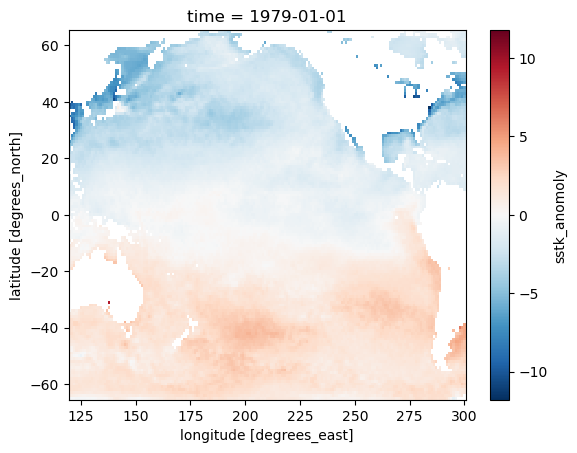

In [22]:
sstk_anomaly.isel(time=0).plot()

## deseaonalization

In [16]:
deseason_sstk_anomaly = sstk_anomaly.groupby('time.month') - sstk_anomaly.groupby('time.month').mean(dim='time')
deseason_sstk_anomaly = deseason_sstk_anomaly.drop('month')

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [23]:
deseason_sstk_anomaly

<xarray.DataArray 'sstk_anomoly' (time: 516, latitude: 131, longitude: 181)>
dask.array<sub, shape=(516, 131, 181), dtype=float32, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## detrending

In [24]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [25]:
detrend_sstk_anomaly = detrend_dim(deseason_sstk_anomaly, 'time', deg=1)

In [26]:
detrend_sstk_anomaly

<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
dask.array<sub, shape=(516, 131, 181), dtype=float64, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## standardization

In [19]:
climatology_mean = detrend_sstk_anomaly.groupby('time.month').mean('time')
climatology_std = detrend_sstk_anomaly.groupby('time.month').std('time')

stand_sstk_anomaly = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                  detrend_sstk_anomaly.groupby('time.month'),
                                  climatology_mean, climatology_std,
                                  dask = 'parallelized')
                                  

In [30]:
stand_sstk_anomaly = stand_sstk_anomaly.drop('month').compute()

In [31]:
stand_sstk_anomaly

<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
array([[[        nan,         nan,         nan, ...,  1.69305587,
          1.69447636,  1.52052848],
        [        nan,         nan,         nan, ...,  1.69362014,
          1.57543038,  1.41486112],
        [        nan,         nan,         nan, ...,  1.61449528,
          1.61442042,  1.65410034],
        ...,
        [-0.38086535, -0.51933748, -0.72513056, ..., -0.58394937,
          0.11502903,  0.08766323],
        [-0.9708576 , -0.98857153, -1.13400839, ..., -0.31682423,
         -0.02845534,         nan],
        [-1.51883697, -1.43294038, -1.47453222, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  1.6926728 ,
          1.69268844,  1.6855551 ],
        [        nan,         nan,         nan, ...,  1.68947729,
          1.67228875,  1.93956271],
        [        nan,         nan,         nan, ...,  1.65145914,
          2.38627112,  1.99554793],
...
        [ 0.21912882,  0.83507645,  1.22698161, ...,  1.93502456,
          1.51158527,  1.09357464],
        [-1.04101187, -1.23313952, -1.23719971, ...,  1.73394191,
          0.96025939,         nan],
        [-1.66725387, -1.66765613, -1.65226291, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -1.45220808,
         -1.29573862, -1.28437198],
        [        nan,         nan,         nan, ..., -1.20725236,
         -0.99661658, -0.21347336],
        [        nan,         nan,         nan, ..., -0.68778838,
         -0.05088461,  0.1638311 ],
        ...,
        [ 0.25416781,  0.34189907,  0.17165537, ...,  0.31008153,
          0.01842813, -1.01953351],
        [-0.09713867, -0.09447981,  0.10794897, ...,  0.39279115,
          0.18185424,         nan],
        [-1.34758879, -1.41096998, -1.36939488, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

# Q3

In [32]:
from eofs.xarray import Eof

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [33]:
coslat = np.cos(np.deg2rad(stand_sstk_anomaly.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(stand_sstk_anomaly, weights=wgts)
eof1 = solver.eofsAsCorrelation(neofs=5)

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


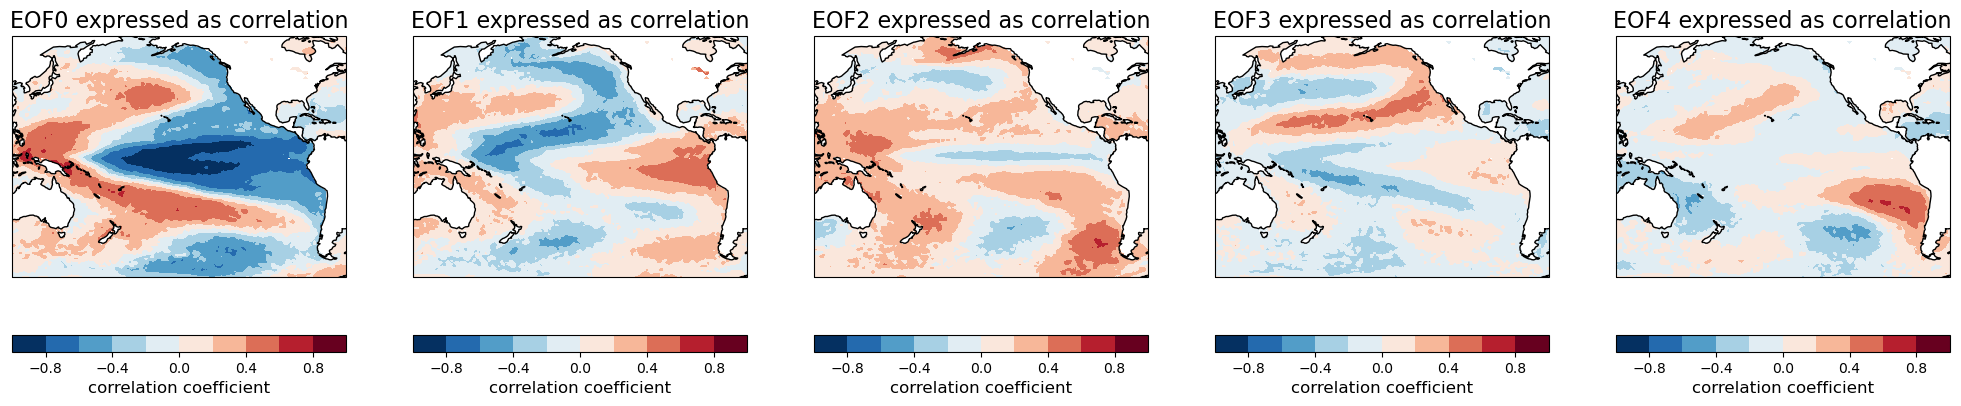

In [74]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=190)})

for i in range(5):
    ax = axs[i]
    clevs = np.linspace(-1, 1, 11)
    # ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
    fill = eof1[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, ax=ax, orientation='horizontal')
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title('EOF'+ str(i)+' expressed as correlation', fontsize=16)

# Q4

In [75]:
varfrac = solver.varianceFraction()

(4.312397074207225e-34, 0.18905759126629312)

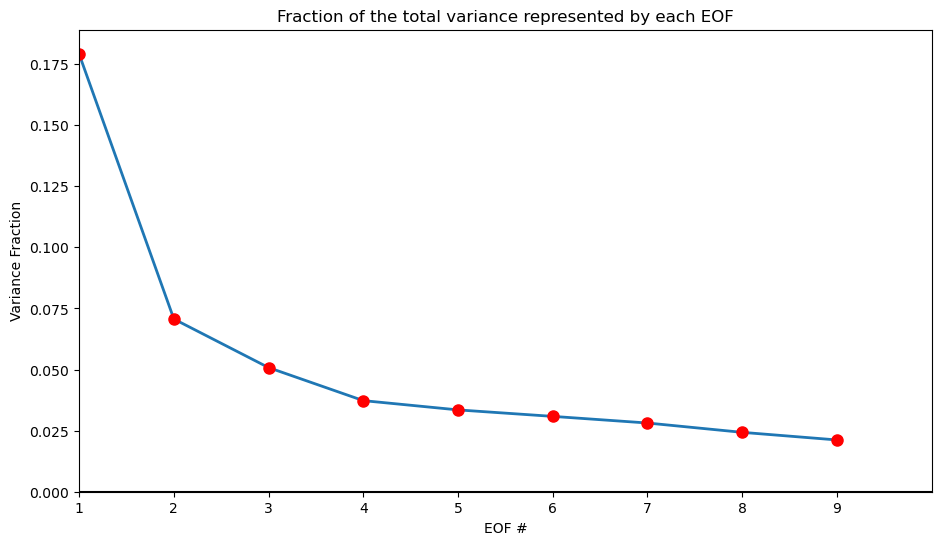

In [79]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 10)
plt.plot(eof_num, varfrac[0:9], linewidth=2)
plt.plot(eof_num, varfrac[0:9], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 10))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

# Q5

In [82]:
reconstruction = solver.reconstructedField(5)

In [90]:
recon_corr = xr.corr(reconstruction, stand_sstk_anomaly, dim='time')

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


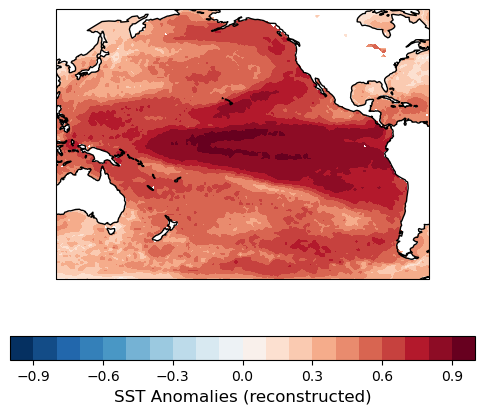

In [110]:
plt.figure(figsize=(6,5))
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = recon_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

# Q6

In [111]:
tp_anomaly = xr.open_dataset('anomaly_dataset.nc', chunks='auto')['tp_anomoly']
deseason_tp_anomaly = tp_anomaly.groupby('time.month') - tp_anomaly.groupby('time.month').mean(dim='time')
deseason_tp_anomaly = deseason_tp_anomaly.drop('month')
detrend_tp_anomaly = detrend_dim(deseason_tp_anomaly, 'time', deg=1)
climatology_tp_mean = detrend_tp_anomaly.groupby('time.month').mean('time')
climatology_tp_std = detrend_tp_anomaly.groupby('time.month').std('time')

stand_tp_anomaly = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                  detrend_tp_anomaly.groupby('time.month'),
                                  climatology_tp_mean, climatology_tp_std,
                                  dask = 'parallelized')
                                  

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [117]:
stand_tp_anomaly = stand_tp_anomaly.compute()

In [118]:
eofn = solver.eofsAsCorrelation(1)

In [119]:
sst_tp_corr = xr.corr(eofn[0], stand_tp_anomaly, dim='time')

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'correlation coefficient between SST and TP')

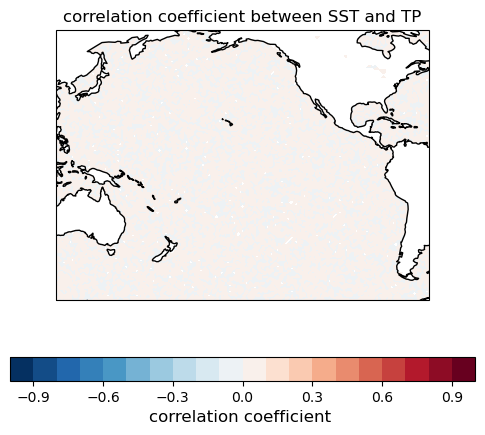

In [124]:
plt.figure(figsize=(6,5))
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst_tp_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient ', fontsize=12)
ax.set_title('correlation coefficient between SST and TP')